In [32]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='3'
DATASET_PATH = '/data/hslee/discrete-jepa/runner/datasets/data'

In [33]:
config= """
model:
  base_learning_rate: 4.5e-06
  target: taming.models.vqgan.VQModel
  params:
    sane_index_shape: true
    embed_dim: 96
    n_embed: 1024
    ddconfig:
      double_z: false
      z_channels: 96
      resolution: 64
      in_channels: 3
      out_ch: 3
      ch: 96
      ch_mult:
      - 1
      - 2
      - 2
      - 4
      - 4
      num_res_blocks: 2
      attn_resolutions:
      - 16
      dropout: 0.0
    lossconfig:
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
      params:
        disc_conditional: false
        disc_in_channels: 3
        disc_start: 10000
        disc_weight: 0.8
        codebook_weight: 1.0
data:
  target: main.DataModuleFromConfig
  params:
    batch_size: 128
    num_workers: 8
    train:
      target: taming.data.dancing_sprites.DSPTrain
      params:
        root: /data/hslee/discrete-jepa/runner/datasets/data/dsp-hard
        video_len: 8
        stochastic_sample: true
        include_labels: false
        size: 64
    validation:
      target: taming.data.dancing_sprites.DSPTest
      params:
        root: /data/hslee/discrete-jepa/runner/datasets/data/dsp-hard
        video_len: 8
        stochastic_sample: true
        include_labels: true
        size: 64
""" 
from omegaconf import OmegaConf as omg

cfg = omg.create(config)

In [34]:
cfg

{'model': {'base_learning_rate': 4.5e-06, 'target': 'taming.models.vqgan.VQModel', 'params': {'sane_index_shape': True, 'embed_dim': 96, 'n_embed': 1024, 'ddconfig': {'double_z': False, 'z_channels': 96, 'resolution': 64, 'in_channels': 3, 'out_ch': 3, 'ch': 96, 'ch_mult': [1, 2, 2, 4, 4], 'num_res_blocks': 2, 'attn_resolutions': [16], 'dropout': 0.0}, 'lossconfig': {'target': 'taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator', 'params': {'disc_conditional': False, 'disc_in_channels': 3, 'disc_start': 10000, 'disc_weight': 0.8, 'codebook_weight': 1.0}}}}, 'data': {'target': 'main.DataModuleFromConfig', 'params': {'batch_size': 128, 'num_workers': 8, 'train': {'target': 'taming.data.dancing_sprites.DSPTrain', 'params': {'root': '/data/hslee/discrete-jepa/runner/datasets/data/dsp-hard', 'video_len': 8, 'stochastic_sample': True, 'include_labels': False, 'size': 64}}, 'validation': {'target': 'taming.data.dancing_sprites.DSPTest', 'params': {'root': '/data/hslee/discrete-jepa/r

### Discrete-JEPA Tokenizer

In [35]:
import numpy as np
import wandb
import torch
import pytorch_lightning as pl 
from hydra import initialize, compose
# Load Configuration
from main import instantiate_from_config

codebook_size = 1024

#tokenizer_ckpt_path='/data/hslee/discrete-jepa/logs/runs/djepa/dancing-sprites-reasoning/250401180922_djepa_dancing-sprites-reasoning_2024-svq4096rndP8T96/version_0/checkpoint/ckpt_199800.ckpt'
#tokenizer_ckpt_path='/data/hslee/discrete-jepa/logs/runs/titok/dancing-sprites-reasoning/250613192509_titok_dancing-sprites-reasoning_2024/version_0/checkpoint/ckpt_24300.ckpt' 
tokenizer_ckpt_path = '/data/hslee/taming-transformers/logs/2025-06-20T11-22-32_custom_vqgan/checkpoints/last.ckpt'



In [36]:
ckpt=torch.load(tokenizer_ckpt_path,weights_only=False,map_location='cuda')
#ckpt['state_dict']

In [37]:
import torch
import hydra
from torch.utils.data import DataLoader

from pytorch_lightning import seed_everything

seed_everything(2024, workers=True)

def load_tokenizer(cfg, tokenizer_ckpt_path):
    tokenizer = instantiate_from_config(cfg.model)
    tokenizer.load_state_dict(torch.load(tokenizer_ckpt_path,weights_only=False,map_location='cuda')['state_dict'])
    tokenizer = tokenizer.eval()
    tokenizer.requires_grad_(False)
    return tokenizer

tokenizer = load_tokenizer(cfg, tokenizer_ckpt_path)

train_dataloader = DataLoader(
    instantiate_from_config(cfg.data.params.train),
    batch_size=128,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    )
# Load Validation Dataset
val_dataloader = DataLoader(
    instantiate_from_config(cfg.data.params.validation),
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    )

Global seed set to 2024


Working with z of shape (1, 96, 4, 4) = 1536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
train dataset has # 57600
test dataset has # 6400


### World Model

In [38]:
from dino_wm import ViTPredictor, ViTCategoricalPredictor, ViTIndex2IndexPredictor, VWorldModel
import torch.nn as nn
import torch.nn.functional as F

In [39]:
from importlib import reload


##### Global Token Extractor

In [40]:
from tqdm import tqdm
from einops import rearrange

def tokenize_all(tokenizer, dataloader, get_factor=False, n_samples_for_dci=1024):
    global_token_collector = []
    patch_token_collector = []
    global_indices_collector = []

    tokenizer.train(False) 
    factors = []
    tokenizer.cuda()
    for batch in tqdm(dataloader):
        if get_factor:
            image, label, mask = batch
        else:
            image = batch
        b = image.size(0)
        image = rearrange(image, 'b t ... -> (b t) ...')
        # prediction

        global_tokens, loss, res = tokenizer.encode(image.cuda())

        indices = res[-1]
        global_indices_collector.append(rearrange(indices,'(b t) h w -> b t (h w)',b=b))

        global_token_collector.append(rearrange(global_tokens,'(b t) d h w -> b t (h w) d', b=b))

        # patch_token_collector.append(patch_tokens)
        if get_factor:
            factors.append(label)
        torch.cuda.empty_cache()
        if len(global_token_collector)*len(image) > n_samples_for_dci:
            break

    global_token_collector = torch.cat(global_token_collector, dim=0) #.squeeze()
    
    #global_token_collector = global_token_collector # b t n d
    # patch_token_collector = torch.cat(patch_token_collector, dim=0) #.squeeze()

    global_indices_collector = torch.cat(global_indices_collector, dim=0)
    print(global_token_collector.shape)
    print(global_indices_collector.shape)
    if get_factor:
        factors = torch.cat(factors, dim=0)
        factors = factors.flatten(start_dim=1,end_dim=2)
    else:
        factors = None
    print(factors.shape)

    _, _, _, L = global_token_collector.size()  # b t n d 
    global_token_concat = global_token_collector.flatten(start_dim=2)

    
    torch.cuda.empty_cache()

    #print('Global Token:', global_token_collector.size()) # [1152, token_size, num_latent_tokens]
    #print('Global Indices:', global_indices_collector.size())
    return global_token_collector, global_indices_collector, factors

#train_global_token, train_global_indices, _ = tokenize_all(tokenizer, train_dataloader)
#val_global_token, val_global_indices, factors = tokenize_all(tokenizer, val_dataloader,get_factor=True)

##### LARS Optimizer

In [41]:
class LARS(torch.optim.Optimizer):
    """
    LARS optimizer, no rate scaling or weight decay for parameters <= 1D.
    """
    def __init__(self, params, lr=0, weight_decay=0, momentum=0.9, trust_coefficient=0.001):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum, trust_coefficient=trust_coefficient)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for g in self.param_groups:
            for p in g['params']:
                dp = p.grad

                if dp is None:
                    continue

                if p.ndim > 1: # if not normalization gamma/beta or bias
                    dp = dp.add(p, alpha=g['weight_decay'])
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(param_norm > 0.,
                                    torch.where(update_norm > 0,
                                    (g['trust_coefficient'] * param_norm / update_norm), one),
                                    one)
                    dp = dp.mul(q)

                param_state = self.state[p]
                if 'mu' not in param_state:
                    param_state['mu'] = torch.zeros_like(p)
                mu = param_state['mu']
                mu.mul_(g['momentum']).add_(dp)
                p.add_(mu, alpha=-g['lr'])

#### Trainer

In [42]:
num_classes_list = [7,7,4] # color, shapes, position

class MultiHeadAttentionPool(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.attention = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.query = nn.Parameter(torch.randn(1, 1, dim))
        
    def forward(self, x):
        # x: [B, N, D]
        query = self.query.expand(x.shape[0], -1, -1)
        out, _ = self.attention(query, x, x)
        return out.squeeze(1)  # [B, D]

class FeatAvgPool(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # bs, seq_len, dims = x.shape
        x = x.permute((0, 2, 1))
        return self.avg_pool(x).squeeze()

def train_classifier(probes, aggregator, tokenizer, val_dataloader, lr=0.1, num_iterations= 20000,n_samples=1024, logging=False, run_name=None):
    global_tokens , global_token_indices, factors = tokenize_all(tokenizer, val_dataloader, get_factor=True, n_samples_for_dci=n_samples)
    
    train_perc=0.75
    num_points = global_tokens.shape[0] * global_tokens.shape[1]
    print('num_points=',num_points)
    global_tokens =global_tokens  # Normalize the global tokens
    perm = np.random.permutation(num_points)
    with torch.no_grad():
        x = rearrange(global_tokens, 'b t n d -> (b t) n d')[perm].cuda()
        factors = rearrange(factors, 'b t c -> (b t) c')[perm]
        x_pooled = aggregator(x)
    x_train = x_pooled[:int(num_points * train_perc)]
    x_test = x_pooled[int(num_points * train_perc):]
    y_train = factors[:int(num_points * train_perc)].long().cuda()
    y_test = factors[int(num_points * train_perc):].long().cuda()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = LARS(probes.parameters(), lr=lr)
    if logging:
        if wandb.run is not None:
            wandb.finish()
        wandb.init(project="djepa", name=run_name)
        wandb.config.update({
            "train_perc": train_perc,
            "num_iterations": num_iterations,
            "num_classes": num_classes_list,
            #"protocol_type": protocol_type
        })
    
    probes.train()
    for iter in tqdm(range(num_iterations)):
        optimizer.zero_grad()
        losses = [criterion(probes[i](x_train), y_train[:, i]) for i in range(len(num_classes_list))]
        
        loss = sum(losses)
        loss.backward()
        optimizer.step()
        # Log training loss
        if iter % 1000 == 0:
            if logging:
                wandb.log({
                    "train_loss": loss.item(),
                }, step=iter)

            # Evaluation and logging final results
            with torch.no_grad():
                test_accuracies = []
                for i in range(len(num_classes_list)):
                    output = probes[i](x_test)
                    preds = output.argmax(-1)
                    accuracy = (preds == y_test[:, i]).float().mean()
                    test_accuracies.append(accuracy.item())
                    print(f"Task {i+1} Accuracy: {accuracy.item():.4f}")

            avg_accuracy = sum(test_accuracies)/len(test_accuracies)
            print(f"Average Accuracy: {avg_accuracy:.4f}")

            # Log final results
            if logging:
                wandb.log({
                    "test_accuracy_task1": test_accuracies[0],
                    "test_accuracy_task2": test_accuracies[1],
                    "test_accuracy_task3": test_accuracies[2],
                    "test_accuracy_avg": avg_accuracy,
                    "test_accuracy_avg12": (test_accuracies[0] + test_accuracies[1])/2
                })

def evaluator(worldmodel, probes, token_pooling, val_dataloader, num_hist, num_pred, truth=False):
    use_post_vq = True
    worldmodel.eval()
    token_pooling.eval()
    if use_post_vq:
        print('using codebook')
        codebook = worldmodel.encoder.quantize.embedding

    eval_loss = []
    eval_index_acc =[]
    
    for batch in tqdm(val_dataloader):
        image, label, _ = batch
        with torch.no_grad():
            
            z_pred, loss, loss_components = worldmodel({'visual': image.cuda()})

            eval_loss.append(loss.item())
            assert z_pred.size(1) == num_pred
            if use_post_vq:
                if not truth:
                    z_pred_idx = torch.argmax(z_pred,dim=-1)
                    z_pred_idx = z_pred_idx[:, 0:num_pred, :] # use only first prediction

                    # index prediction accuracy 
                    r = (loss_components['z_tgt'].detach()==z_pred_idx).flatten(start_dim=0)
                    eval_index_acc.append(r.sum().item()/len(r))

                    # quantize the predicted indices
                    z_pred_quantized=  rearrange(codebook(z_pred_idx.flatten()),'(b t n) d -> (b t) n d', b=len(z_pred), t=num_pred)
                    z_pred_pooled = token_pooling(z_pred_quantized) # (b t) d
                else:
                    print('caution: evaluating ground truth')
                    gt_, _, res = worldmodel.encoder.encode(rearrange(image.cuda(),'b t ... -> (b t) ...'))
                    gt_ = rearrange(gt_, '(b t) d h w -> b t (h w) d', b=len(z_pred))[:, num_hist:num_hist+num_pred]
                    #ind = rearrange(res['min_encoding_indices'],'(b t) 1 p -> b t p', b=len(z_pred))
                    z_pred_pooled = token_pooling(rearrange(gt_, 'b t n d -> (b t) n d')) # (b t) d
            else:
                z_pred_pooled = token_pooling(rearrange(z_pred, 'b t n d -> (b t) n d'))
            
            label_last = label[:, num_hist:num_hist+num_pred, 0].cuda()
            test_accuracies = [[] for _ in range(num_pred)]
            for i in range(len(num_classes_list)):
                output = probes[i](z_pred_pooled)
                #print(output.shape)
                preds = rearrange(output.argmax(-1),'(b t) -> b t', b=len(z_pred))
                #print(preds, label_last[:, i])
                accuracies = (preds == label_last[:, :, i]).float()
                for ts in range(num_pred):
                    test_accuracies[ts].append(accuracies[:, ts].mean().item())
                    
                    #print(f"Task {i+1} Accuracy: {accuracy.item():.4f}")
    accs = [[0]*num_pred for _ in num_classes_list]
    
    for i in range(len(num_classes_list)):
        for ts in range(num_pred):
            s = test_accuracies[ts][i::len(num_classes_list)]
            _ac=sum(s)/len(s)
            accs[i][ts]=_ac
            print(f"Task {i+1} Accuracy future +{ts+1}: {_ac:.4f}")
    return eval_loss, eval_index_acc, accs

def train_worldmodel(worldmodel, train_dataloader, val_dataloader, lr, num_epochs = 10,postfix="", num_hist=cfg.data.params.train.params.video_len//2, num_pred=1, load_ckpt=None, token_pooling=None, probes=None, logging=True):
    assert num_hist >= num_pred
    use_post_vq=True
    if load_ckpt is not None:
        worldmodel.load_state_dict(torch.load(load_ckpt,map_location='cuda',weights_only=False))
        return worldmodel
    if logging:
        if wandb.run is not None:
            wandb.finish()
        wandb.init(project="lightning_logs", config=dict(cfg), name=f"wm_dsph_lr{lr}_ep{num_epochs}{postfix}_vqgan")
        wandb.config.update({'num_hist':num_hist, 'num_pred':num_pred, 'wm_lr':lr})

    optimizer = torch.optim.Adam(worldmodel.parameters(), lr=lr)
    global_step = 0
    for epoch in range(num_epochs):
        worldmodel.train()
        
        epoch_loss = []
        bar = tqdm(train_dataloader)
        for batch in bar:
            
            z_pred, loss, loss_components = worldmodel({'visual': batch.cuda()})

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(worldmodel.parameters(), max_norm=10.0)
            optimizer.step()
            
            epoch_loss.append(loss.item())
            bar.set_description(f'Train Loss: {loss.item():.5f}')
            if logging:
                wandb.log({'wm_train_loss': loss.item(), 'wm_lr': lr},step=global_step)
            global_step+=1
            
            
        #print(f"Epoch {epoch} train_loss={sum(epoch_loss)/len(epoch_loss):.5f}")
        if (epoch+1) % 5 == 0:
            torch.save(worldmodel.state_dict(),f'wm_dsph_lr{lr}_ep{epoch+1}{postfix}_titok.ckpt')
        worldmodel.eval()
        
            
        eval_loss, eval_index_acc, accs = evaluator(worldmodel, probes, token_pooling, val_dataloader, num_hist, num_pred, )
        print(f"Epoch {epoch} val_loss={sum(eval_loss)/len(eval_loss):.5f} {'indexing_acc '+str(sum(eval_index_acc)/len(eval_index_acc)).format('.5f') if use_post_vq  else ''}")
        if logging:
            wandb.log({'wm_val_loss': sum(eval_loss)/len(eval_loss)},step=global_step)
            for i in range(len(probes)):
                for ts in range(num_pred):
                    wandb.log({f"task{i+1}_acc_ts{ts+1}":accs[i][ts] }, step=global_step)
        #torch.save(worldmodel.state_dict(),f'worldmodel_dsp_lr{lr}_ep{epoch+1}_hist{num_hist}_d{model_dim}l{depth}h{heads}mh{mlp_hidden_dim}ah{attn_head_dim}dr{dropout}{postfix}.ckpt')
    if logging:
        wandb.finish()


### Run

In [43]:
# Create postfix for logging
token_size = str(96)
num_latent_tokens = str(16)
vq_mode = f"-V{codebook_size}" 

num_hist = cfg.data.params.train.params.video_len //2
num_pred = cfg.data.params.train.params.video_len //2
use_post_vq=True
input_indices = True

postfix = f"-T{token_size}-L{num_latent_tokens}{vq_mode}-H{num_hist}-{'r2r' if not use_post_vq else ('i2i' if input_indices else 'r2i') }"

#### Train Classifier

In [44]:
#wandb.finish()

In [45]:
seed_everything(2024, workers=True)
# probes = nn.ModuleList(nn.Sequential(nn.Linear(cfg.worldmodel.vq_model.token_size, hidden_dim), 
#                                      nn.ReLU(),
#                                      nn.Linear(hidden_dim, num_classes)
#                                      ) 
#         for num_classes in num_classes_list).cuda()
probes = nn.ModuleList(nn.Linear(96*16, num_classes) 
        for num_classes in num_classes_list).cuda()
#aggregator = MultiHeadAttentionPool(dim=cfg.worldmodel.vq_model.token_size, num_heads=1).cuda()
#aggregator = FeatAvgPool().cuda()
aggregator = nn.Flatten(start_dim=-2, end_dim=-1).cuda()

if True:
    train_classifier(probes, aggregator, tokenizer, val_dataloader, lr=0.1,n_samples=np.inf,num_iterations=10000,logging=False, run_name=f"cls_dsph_lr0.1_ep10000_avgpool")
    torch.save(probes.state_dict(),'cls_dsph_lr0.1_ep10000_flatten_vqvae_96')
    if wandb.run is not None:
        wandb.finish()
else:
    probes.load_state_dict(torch.load('/data/hslee/taming-transformers/cls_dsph_lr0.1_ep10000_flatten_vqvae_96'))

Global seed set to 2024
100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


torch.Size([6400, 8, 16, 96])
torch.Size([6400, 8, 16])
torch.Size([6400, 8, 3])
num_points= 51200


  0%|          | 33/10000 [00:00<00:31, 318.84it/s]

Task 1 Accuracy: 0.1687
Task 2 Accuracy: 0.1713
Task 3 Accuracy: 0.0882
Average Accuracy: 0.1427


 10%|█         | 1040/10000 [00:04<00:40, 223.81it/s]

Task 1 Accuracy: 0.9100
Task 2 Accuracy: 0.3456
Task 3 Accuracy: 0.9780
Average Accuracy: 0.7446


 20%|██        | 2029/10000 [00:08<00:35, 227.17it/s]

Task 1 Accuracy: 0.9392
Task 2 Accuracy: 0.3456
Task 3 Accuracy: 0.9839
Average Accuracy: 0.7562


 30%|███       | 3041/10000 [00:13<00:30, 225.83it/s]

Task 1 Accuracy: 0.9621
Task 2 Accuracy: 0.3457
Task 3 Accuracy: 0.9834
Average Accuracy: 0.7637


 40%|████      | 4030/10000 [00:17<00:26, 225.33it/s]

Task 1 Accuracy: 0.9677
Task 2 Accuracy: 0.3456
Task 3 Accuracy: 0.9834
Average Accuracy: 0.7656


 50%|█████     | 5042/10000 [00:22<00:21, 226.01it/s]

Task 1 Accuracy: 0.9680
Task 2 Accuracy: 0.3459
Task 3 Accuracy: 0.9834
Average Accuracy: 0.7658


 60%|██████    | 6032/10000 [00:26<00:17, 225.41it/s]

Task 1 Accuracy: 0.9680
Task 2 Accuracy: 0.3459
Task 3 Accuracy: 0.9834
Average Accuracy: 0.7658


 70%|███████   | 7030/10000 [00:30<00:13, 224.59it/s]

Task 1 Accuracy: 0.9679
Task 2 Accuracy: 0.3459
Task 3 Accuracy: 0.9834
Average Accuracy: 0.7657


 80%|████████  | 8042/10000 [00:35<00:08, 224.87it/s]

Task 1 Accuracy: 0.9680
Task 2 Accuracy: 0.3458
Task 3 Accuracy: 0.9834
Average Accuracy: 0.7658


 90%|█████████ | 9032/10000 [00:39<00:04, 225.28it/s]

Task 1 Accuracy: 0.9681
Task 2 Accuracy: 0.3458
Task 3 Accuracy: 0.9834
Average Accuracy: 0.7658


100%|██████████| 10000/10000 [00:43<00:00, 228.58it/s]


In [46]:
import importlib
import dino_wm
importlib.reload(dino_wm)
from dino_wm import ViTPredictor, ViTCategoricalPredictor, ViTIndex2IndexPredictor, VWorldModel

In [48]:
# R : distributed Representation
# I : codebook Index of representation
# QR : Quantized Representation
depth=2
heads=4
model_dim=96
mlp_hidden_dim=256
attn_head_dim=32
dropout=0.3
emb_dropout=0.
seed_everything(2024, workers=True)

        # I -> I
predictor =  ViTIndex2IndexPredictor(num_patches=16, 
                num_frames=num_hist,
                codebook_size=1024,
                dim=model_dim,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_hidden_dim, 
                pool='mean',
                dim_head=attn_head_dim,
                dropout=dropout,
                emb_dropout=emb_dropout).cuda()


wm = VWorldModel(cfg,use_post_vq=use_post_vq,num_hist=num_hist, num_pred=num_pred, encoder=tokenizer,predictor=predictor, train_encoder=False, train_predictor=True, input_indices=input_indices, djepa=True).cuda()

print(postfix)
train_worldmodel(wm, train_dataloader, val_dataloader, lr=1e-3, num_epochs=15, postfix=postfix, num_hist=num_hist, num_pred=num_pred, token_pooling=aggregator, probes=probes, logging=True)#, load_ckpt='wm_dsph_lr0.001_ep30-T96-L8-V4096-H4-r2i_titok.ckpt')
#train_worldmodel(wm, train_dataloader, val_dataloader, lr=1e-3, num_epochs=30, postfix=postfix, num_hist=num_hist, num_pred=num_pred, token_pooling=aggregator, probes=probes, logging=True)

Global seed set to 2024


-T96-L16-V1024-H4-i2i


wandb: Currently logged in as: gitpush-force (confeito) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Train Loss: 1.26341: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Task 1 Accuracy future +1: 0.3984
Task 1 Accuracy future +2: 0.4219
Task 1 Accuracy future +3: 0.5781
Task 1 Accuracy future +4: 0.3438
Task 2 Accuracy future +1: 0.3047
Task 2 Accuracy future +2: 0.2734
Task 2 Accuracy future +3: 0.3047
Task 2 Accuracy future +4: 0.2891
Task 3 Accuracy future +1: 0.9922
Task 3 Accuracy future +2: 0.9844
Task 3 Accuracy future +3: 0.9844
Task 3 Accuracy future +4: 0.9688
Epoch 0 val_loss=1.24746 indexing_acc 0.59390869140625


Train Loss: 1.08529: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Task 1 Accuracy future +1: 0.6250
Task 1 Accuracy future +2: 0.6328
Task 1 Accuracy future +3: 0.5938
Task 1 Accuracy future +4: 0.3125
Task 2 Accuracy future +1: 0.2656
Task 2 Accuracy future +2: 0.3359
Task 2 Accuracy future +3: 0.2969
Task 2 Accuracy future +4: 0.3359
Task 3 Accuracy future +1: 0.9609
Task 3 Accuracy future +2: 0.9688
Task 3 Accuracy future +3: 0.9766
Task 3 Accuracy future +4: 0.9766
Epoch 1 val_loss=1.09490 indexing_acc 0.6612890625


Train Loss: 1.11136: 100%|██████████| 450/450 [03:25<00:00,  2.19it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Task 1 Accuracy future +1: 0.6719
Task 1 Accuracy future +2: 0.6641
Task 1 Accuracy future +3: 0.6641
Task 1 Accuracy future +4: 0.3281
Task 2 Accuracy future +1: 0.3125
Task 2 Accuracy future +2: 0.3047
Task 2 Accuracy future +3: 0.3047
Task 2 Accuracy future +4: 0.3359
Task 3 Accuracy future +1: 0.9688
Task 3 Accuracy future +2: 0.9844
Task 3 Accuracy future +3: 0.9688
Task 3 Accuracy future +4: 0.9844
Epoch 2 val_loss=0.98642 indexing_acc 0.7018310546875


Train Loss: 0.97244: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Task 1 Accuracy future +1: 0.6719
Task 1 Accuracy future +2: 0.6562
Task 1 Accuracy future +3: 0.6562
Task 1 Accuracy future +4: 0.4844
Task 2 Accuracy future +1: 0.3047
Task 2 Accuracy future +2: 0.3125
Task 2 Accuracy future +3: 0.2891
Task 2 Accuracy future +4: 0.3047
Task 3 Accuracy future +1: 0.9844
Task 3 Accuracy future +2: 0.9844
Task 3 Accuracy future +3: 0.9766
Task 3 Accuracy future +4: 0.9844
Epoch 3 val_loss=0.75363 indexing_acc 0.74899169921875


Train Loss: 0.67188: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Task 1 Accuracy future +1: 0.7031
Task 1 Accuracy future +2: 0.7188
Task 1 Accuracy future +3: 0.7422
Task 1 Accuracy future +4: 0.8438
Task 2 Accuracy future +1: 0.3047
Task 2 Accuracy future +2: 0.2734
Task 2 Accuracy future +3: 0.3281
Task 2 Accuracy future +4: 0.3047
Task 3 Accuracy future +1: 0.9844
Task 3 Accuracy future +2: 0.9766
Task 3 Accuracy future +3: 0.9844
Task 3 Accuracy future +4: 0.9844
Epoch 4 val_loss=0.51015 indexing_acc 0.82708984375


Train Loss: 0.67970: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Task 1 Accuracy future +1: 0.7422
Task 1 Accuracy future +2: 0.7188
Task 1 Accuracy future +3: 0.7500
Task 1 Accuracy future +4: 0.9141
Task 2 Accuracy future +1: 0.3047
Task 2 Accuracy future +2: 0.3359
Task 2 Accuracy future +3: 0.3203
Task 2 Accuracy future +4: 0.2734
Task 3 Accuracy future +1: 0.9844
Task 3 Accuracy future +2: 0.9844
Task 3 Accuracy future +3: 0.9766
Task 3 Accuracy future +4: 0.9922
Epoch 5 val_loss=0.46988 indexing_acc 0.83730224609375


Train Loss: 0.55286: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Task 1 Accuracy future +1: 0.6953
Task 1 Accuracy future +2: 0.7500
Task 1 Accuracy future +3: 0.7578
Task 1 Accuracy future +4: 0.8906
Task 2 Accuracy future +1: 0.3203
Task 2 Accuracy future +2: 0.3047
Task 2 Accuracy future +3: 0.2969
Task 2 Accuracy future +4: 0.3125
Task 3 Accuracy future +1: 0.9844
Task 3 Accuracy future +2: 0.9922
Task 3 Accuracy future +3: 0.9688
Task 3 Accuracy future +4: 0.9922
Epoch 6 val_loss=0.46378 indexing_acc 0.83968017578125


Train Loss: 0.58900: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Task 1 Accuracy future +1: 0.7031
Task 1 Accuracy future +2: 0.7422
Task 1 Accuracy future +3: 0.7344
Task 1 Accuracy future +4: 0.9297
Task 2 Accuracy future +1: 0.3047
Task 2 Accuracy future +2: 0.3438
Task 2 Accuracy future +3: 0.2734
Task 2 Accuracy future +4: 0.3203
Task 3 Accuracy future +1: 0.9766
Task 3 Accuracy future +2: 0.9922
Task 3 Accuracy future +3: 0.9766
Task 3 Accuracy future +4: 0.9922
Epoch 7 val_loss=0.46167 indexing_acc 0.83996826171875


Train Loss: 0.58638: 100%|██████████| 450/450 [03:23<00:00,  2.21it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Task 1 Accuracy future +1: 0.7266
Task 1 Accuracy future +2: 0.7266
Task 1 Accuracy future +3: 0.7422
Task 1 Accuracy future +4: 0.9297
Task 2 Accuracy future +1: 0.2812
Task 2 Accuracy future +2: 0.3203
Task 2 Accuracy future +3: 0.2812
Task 2 Accuracy future +4: 0.2969
Task 3 Accuracy future +1: 0.9844
Task 3 Accuracy future +2: 0.9844
Task 3 Accuracy future +3: 0.9922
Task 3 Accuracy future +4: 0.9844
Epoch 8 val_loss=0.45608 indexing_acc 0.84221923828125


Train Loss: 0.60716: 100%|██████████| 450/450 [03:23<00:00,  2.21it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Task 1 Accuracy future +1: 0.7344
Task 1 Accuracy future +2: 0.7344
Task 1 Accuracy future +3: 0.6953
Task 1 Accuracy future +4: 0.9688
Task 2 Accuracy future +1: 0.3125
Task 2 Accuracy future +2: 0.2969
Task 2 Accuracy future +3: 0.3047
Task 2 Accuracy future +4: 0.3047
Task 3 Accuracy future +1: 0.9922
Task 3 Accuracy future +2: 0.9844
Task 3 Accuracy future +3: 0.9844
Task 3 Accuracy future +4: 0.9844
Epoch 9 val_loss=0.44976 indexing_acc 0.8443994140625


Train Loss: 0.49813: 100%|██████████| 450/450 [03:23<00:00,  2.21it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Task 1 Accuracy future +1: 0.7500
Task 1 Accuracy future +2: 0.7422
Task 1 Accuracy future +3: 0.7109
Task 1 Accuracy future +4: 0.9609
Task 2 Accuracy future +1: 0.3047
Task 2 Accuracy future +2: 0.2969
Task 2 Accuracy future +3: 0.3359
Task 2 Accuracy future +4: 0.3047
Task 3 Accuracy future +1: 0.9844
Task 3 Accuracy future +2: 0.9688
Task 3 Accuracy future +3: 0.9844
Task 3 Accuracy future +4: 0.9844
Epoch 10 val_loss=0.44550 indexing_acc 0.84618408203125


Train Loss: 0.66394: 100%|██████████| 450/450 [03:22<00:00,  2.22it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Task 1 Accuracy future +1: 0.7266
Task 1 Accuracy future +2: 0.7344
Task 1 Accuracy future +3: 0.7188
Task 1 Accuracy future +4: 0.9609
Task 2 Accuracy future +1: 0.2812
Task 2 Accuracy future +2: 0.2891
Task 2 Accuracy future +3: 0.3125
Task 2 Accuracy future +4: 0.3125
Task 3 Accuracy future +1: 0.9844
Task 3 Accuracy future +2: 0.9922
Task 3 Accuracy future +3: 0.9844
Task 3 Accuracy future +4: 0.9922
Epoch 11 val_loss=0.44206 indexing_acc 0.84693115234375


Train Loss: 0.46050: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Task 1 Accuracy future +1: 0.7344
Task 1 Accuracy future +2: 0.7422
Task 1 Accuracy future +3: 0.7266
Task 1 Accuracy future +4: 0.9609
Task 2 Accuracy future +1: 0.3047
Task 2 Accuracy future +2: 0.3359
Task 2 Accuracy future +3: 0.3047
Task 2 Accuracy future +4: 0.2969
Task 3 Accuracy future +1: 0.9766
Task 3 Accuracy future +2: 0.9844
Task 3 Accuracy future +3: 0.9844
Task 3 Accuracy future +4: 0.9844
Epoch 12 val_loss=0.43993 indexing_acc 0.84753662109375


Train Loss: 0.45318: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Task 1 Accuracy future +1: 0.7344
Task 1 Accuracy future +2: 0.7500
Task 1 Accuracy future +3: 0.7344
Task 1 Accuracy future +4: 0.9688
Task 2 Accuracy future +1: 0.2812
Task 2 Accuracy future +2: 0.2734
Task 2 Accuracy future +3: 0.2969
Task 2 Accuracy future +4: 0.3281
Task 3 Accuracy future +1: 0.9766
Task 3 Accuracy future +2: 0.9922
Task 3 Accuracy future +3: 0.9844
Task 3 Accuracy future +4: 0.9922
Epoch 13 val_loss=0.43688 indexing_acc 0.84786376953125


Train Loss: 0.48494: 100%|██████████| 450/450 [03:24<00:00,  2.20it/s]


using codebook


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Task 1 Accuracy future +1: 0.7344
Task 1 Accuracy future +2: 0.7188
Task 1 Accuracy future +3: 0.7422
Task 1 Accuracy future +4: 0.9531
Task 2 Accuracy future +1: 0.3203
Task 2 Accuracy future +2: 0.3125
Task 2 Accuracy future +3: 0.2891
Task 2 Accuracy future +4: 0.3047
Task 3 Accuracy future +1: 0.9688
Task 3 Accuracy future +2: 0.9922
Task 3 Accuracy future +3: 0.9688
Task 3 Accuracy future +4: 0.9922
Epoch 14 val_loss=0.43579 indexing_acc 0.84895263671875


task1_acc_ts1,▁▆▆▆▇█▇▇███████
task1_acc_ts2,▁▅▆▆▇▇██▇█████▇
task1_acc_ts3,▁▂▄▄▇██▇▇▆▆▆▇▇▇
task1_acc_ts4,▁▁▁▃▇▇▇████████
task2_acc_ts1,▆▁▇▆▆▆█▆▃▇▆▃▆▃█
task2_acc_ts2,▁▇▄▅▁▇▄█▆▃▃▃▇▁▅
task2_acc_ts3,▅▄▅▃▇▆▄▁▂▅█▅▅▄▃
task2_acc_ts4,▃██▅▅▁▅▆▄▅▅▅▄▇▅
task3_acc_ts1,█▁▃▆▆▆▆▅▆█▆▆▅▅▃
task3_acc_ts2,▆▁▆▆▃▆██▆▆▁█▆██
task3_acc_ts3,▆▃▁▃▆▃▁▃█▆▆▆▆▆▁


In [ ]:
#del wandb
import wandb

### Autoregressive Evaluation

In [ ]:
def evaluator_ar(worldmodel, probes, token_pooling, val_dataloader, num_hist, num_ar_pred):
    
    worldmodel.eval()
    token_pooling.eval()
    if use_post_vq:
        codebook = worldmodel.encoder.quantize.get_codebook_entry
    
    for batch in tqdm(val_dataloader):
        image, label, _ = batch
        with torch.no_grad():
            
            z_pred = worldmodel.rollout({'visual': image[:, :num_hist].cuda()},num_ar_pred)
            z_pred = z_pred[:, num_hist:, ...]
            #z_pred : b num_ar_pred n d

            if worldmodel.use_post_vq and worldmodel.input_indices: # z_pred is indices
                z_pred = z_pred.squeeze(-1)
                # b num_ar_pred n
                z_pred_quantized=  rearrange(codebook(z_pred.flatten(), (len(z_pred)*num_ar_pred, 4,4,96)),'(b t n) d -> (b t) n d', b=len(z_pred), t=num_ar_pred)
                z_pred_pooled = token_pooling(z_pred_quantized) # (b t) d

            else:
                z_pred_pooled = token_pooling(rearrange(z_pred, 'b t n d -> (b t) n d'))
                
            #z_pred_pooled (b t) d
            label_last = label[:, num_hist:num_hist+num_ar_pred, 0].cuda()
            test_accuracies = [[] for _ in range(num_ar_pred)]
            for i in range(len(num_classes_list)):
                output = probes[i](z_pred_pooled)
                #print(output.shape)
                preds = rearrange(output.argmax(-1),'(b t) -> b t', b=len(z_pred))
                #print(preds, label_last[:, i])
                accuracies = (preds == label_last[:, :, i]).float()
                for ts in range(num_ar_pred):
                    test_accuracies[ts].append(accuracies[:, ts].mean().item())
                    
                    #print(f"Task {i+1} Accuracy: {accuracy.item():.4f}")
    accs = [[0]*num_ar_pred for _ in num_classes_list]
    
    for i in range(len(num_classes_list)):
        for ts in range(num_ar_pred):
            s = test_accuracies[ts][i::len(num_classes_list)]
            _ac=sum(s)/len(s)
            accs[i][ts]=_ac
            print(f"Task {i+1:02d} Accuracy future +{ts+1:02d}: {_ac:.4f}")
        print()
    return accs

In [60]:
def evaluator_ar_inf(worldmodel, probes, token_pooling, val_dataloader, num_hist, num_ar_pred):
    
    worldmodel.eval()
    token_pooling.eval()
    if use_post_vq:
        codebook = worldmodel.encoder.quantize.embedding
    
    rep = (num_hist+num_ar_pred)//84+1
    mses = torch.zeros(num_ar_pred)
    tot_p = 0
    for batch in tqdm(val_dataloader):
        image, label, _ = batch
        with torch.no_grad():
            
            z_pred = worldmodel.rollout({'visual': image[:, :num_hist].cuda()},num_ar_pred,inc=num_hist)
            #print(z_pred.shape)
            z_pred = z_pred[:, num_hist:, ...]
            #z_pred : b num_ar_pred n d
            z_target = worldmodel.encode({'visual': image.cuda()})
            z_ = []
            l_ = []
            
            for zz, ll in zip(z_target, label):
                if ll[0, 0, 0] == ll[7, 0, 0]:
                    ll = ll[:7].repeat(12, 1, 1)
                    zz = zz[:7].repeat(12, 1, 1)
                elif ll[0, 0, 0] == ll[4, 0, 0]:
                    ll = ll[:4].repeat(21, 1, 1)
                    zz = zz[:4].repeat(21, 1, 1)
                elif ll[0, 0, 0] == ll[3, 0, 0]:
                    ll = ll[:3].repeat(28, 1, 1)
                    zz = zz[:3].repeat(28, 1, 1)
                else:
                    print('what?')
                    print(ll)
                z_.append(zz)
                l_.append(ll)
            z_target = torch.stack(z_, dim=0)
            label = torch.stack(l_, dim=0)
            z_target = z_target.repeat(1, rep, 1, 1)[:,num_hist:num_hist+num_ar_pred]

            #z_pred_pooled (b t) d
            label = label.repeat(1, rep ,1,1)
            label_last = label[:, num_hist:num_hist+num_ar_pred, 0].cuda()

            tot_p+=len(image)
            mses += F.mse_loss(z_pred, z_target,reduction='none').sum((0, 2, 3)).cpu()
            if worldmodel.use_post_vq and worldmodel.input_indices: # z_pred is indices
                z_pred = z_pred.squeeze(-1)
                # b num_ar_pred n
                z_pred_quantized=  rearrange(codebook(z_pred.flatten()),'(b t n) d -> (b t) n d', b=len(z_pred), t=num_ar_pred)
                z_pred_pooled = token_pooling(z_pred_quantized) # (b t) d

            else:
                z_pred_pooled = token_pooling(rearrange(z_pred, 'b t n d -> (b t) n d'))
            test_accuracies = [[] for _ in range(num_ar_pred)]
            for i in range(len(num_classes_list)):
                output = probes[i](z_pred_pooled)
                #print(output.shape)
                preds = rearrange(output.argmax(-1),'(b t) -> b t', b=len(z_pred))
                #print(preds, label_last[:, i])
                accuracies = (preds == label_last[:, :, i]).float()
                for ts in range(num_ar_pred):
                    test_accuracies[ts].append(accuracies[:, ts].mean().item())
                    
                    #print(f"Task {i+1} Accuracy: {accuracy.item():.4f}")
    accs = [[0]*num_ar_pred for _ in num_classes_list]
    
    for i in range(len(num_classes_list)):
        for ts in range(num_ar_pred):
            s = test_accuracies[ts][i::len(num_classes_list)]
            _ac=sum(s)/len(s)
            accs[i][ts]=_ac
            print(f"Task {i+1:02d} Accuracy future +{ts+1:02d}: {_ac:.4f}")
        print()
    return accs, (mses/tot_p).numpy()

Global seed set to 2024
  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_228994/221817842.py:47: UserWarning: Using a target size (torch.Size([128, 200, 16, 96])) that is different to the input size (torch.Size([128, 200, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mses += F.mse_loss(z_pred, z_target,reduction='none').sum((0, 2, 3)).cpu()
100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Task 01 Accuracy future +01: 0.7578
Task 01 Accuracy future +02: 0.6953
Task 01 Accuracy future +03: 0.7188
Task 01 Accuracy future +04: 0.9453
Task 01 Accuracy future +05: 0.7734
Task 01 Accuracy future +06: 0.7266
Task 01 Accuracy future +07: 0.7266
Task 01 Accuracy future +08: 0.7031
Task 01 Accuracy future +09: 0.7500
Task 01 Accuracy future +10: 0.7031
Task 01 Accuracy future +11: 0.7656
Task 01 Accuracy future +12: 0.7500
Task 01 Accuracy future +13: 0.7734
Task 01 Accuracy future +14: 0.7188
Task 01 Accuracy future +15: 0.7500
Task 01 Accuracy future +16: 0.6953
Task 01 Accuracy future +17: 0.7109
Task 01 Accuracy future +18: 0.7969
Task 01 Accuracy future +19: 0.7500
Task 01 Accuracy future +20: 0.7188
Task 01 Accuracy future +21: 0.7422
Task 01 Accuracy future +22: 0.7266
Task 01 Accuracy future +23: 0.7422
Task 01 Accuracy future +24: 0.7031
Task 01 Accuracy future +25: 0.7812
Task 01 Accuracy future +26: 0.7188
Task 01 Accuracy future +27: 0.7344
Task 01 Accuracy future +28:

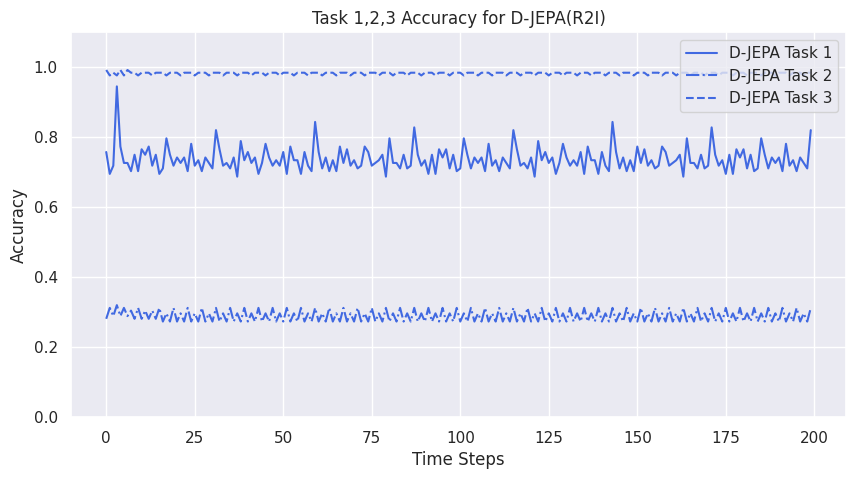

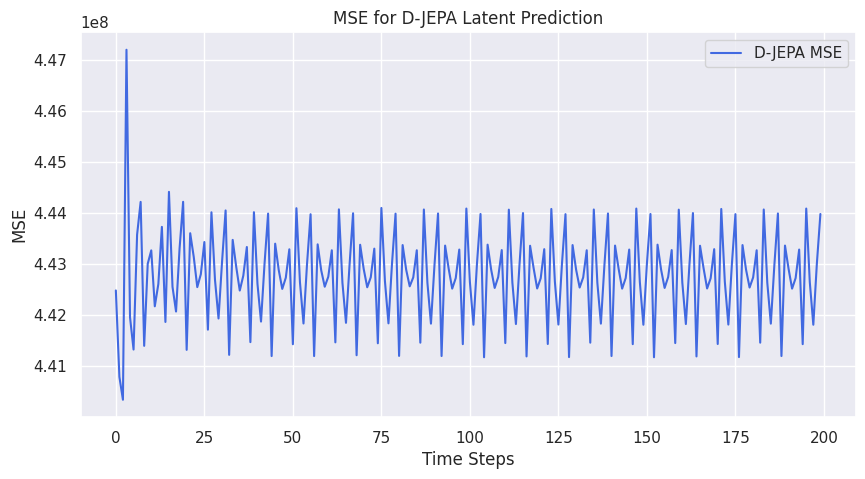

In [61]:

seed_everything(2024, workers=True)
# Load Validation Dataset
# val_dataloader = DataLoader(
#     hydra.utils.instantiate(cfg.dataset.valset),
#     batch_size=cfg.dataset.batch_size, 
#     shuffle=False,
#     num_workers=cfg.dataset.num_workers,
#     pin_memory=False,
#     )

#evaluator_ar(wm, probes, aggregator, val_dataloader, num_hist, num_ar_pred=20)
task,mses = evaluator_ar_inf(wm, probes,aggregator, val_dataloader, num_hist, num_ar_pred=200)
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_theme()
plt.figure(figsize=(10, 5))
sns.lineplot(task[0], label='D-JEPA Task 1', color='royalblue', linestyle='-')
sns.lineplot(task[1], label='D-JEPA Task 2', color='royalblue', linestyle='-.')
sns.lineplot(task[2], label='D-JEPA Task 3', color='royalblue', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Time Steps')
plt.ylim((0,1.1))
plt.legend( loc='upper right')
plt.title('Task 1,2,3 Accuracy for D-JEPA(R2I)')
plt.show()

sns.set_theme()
plt.figure(figsize=(10, 5))
sns.lineplot(mses, label='D-JEPA MSE', color='royalblue', linestyle='-')

plt.ylabel('MSE')
plt.xlabel('Time Steps')
plt.legend( loc='upper right')
plt.title('MSE for D-JEPA Latent Prediction')
plt.show()


In [63]:
str(task)

'[[0.7578125, 0.6953125, 0.71875, 0.9453125, 0.7734375, 0.7265625, 0.7265625, 0.703125, 0.75, 0.703125, 0.765625, 0.75, 0.7734375, 0.71875, 0.75, 0.6953125, 0.7109375, 0.796875, 0.75, 0.71875, 0.7421875, 0.7265625, 0.7421875, 0.703125, 0.78125, 0.71875, 0.734375, 0.703125, 0.7421875, 0.7265625, 0.7109375, 0.8203125, 0.765625, 0.71875, 0.7265625, 0.7109375, 0.7421875, 0.6875, 0.7890625, 0.734375, 0.7578125, 0.7265625, 0.7421875, 0.6953125, 0.7265625, 0.78125, 0.7421875, 0.71875, 0.734375, 0.71875, 0.7578125, 0.6953125, 0.7734375, 0.734375, 0.734375, 0.6953125, 0.7578125, 0.71875, 0.703125, 0.84375, 0.7578125, 0.7109375, 0.7421875, 0.703125, 0.734375, 0.703125, 0.7734375, 0.7265625, 0.765625, 0.71875, 0.734375, 0.7109375, 0.71875, 0.7734375, 0.7578125, 0.71875, 0.7265625, 0.734375, 0.75, 0.6875, 0.796875, 0.7265625, 0.7265625, 0.7109375, 0.75, 0.7109375, 0.71875, 0.828125, 0.75, 0.71875, 0.734375, 0.6953125, 0.75, 0.6953125, 0.765625, 0.7421875, 0.765625, 0.7109375, 0.75, 0.703125, 0.710

In [ ]:
mses.tolist()

In [ ]:
ijepa_task = np.array([[1.0, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.984375, 1.0, 0.9765625, 0.9765625, 0.9765625, 0.9765625, 0.953125, 0.984375, 0.9453125, 0.96875, 0.9296875, 0.9296875, 0.9375, 0.9296875, 0.890625, 0.8984375, 0.8828125, 0.8984375, 0.875, 0.875, 0.8984375, 0.8671875, 0.796875, 0.8984375, 0.8515625, 0.8046875, 0.828125, 0.828125, 0.7890625, 0.8046875, 0.8203125, 0.78125, 0.796875, 0.78125, 0.7421875, 0.796875, 0.765625, 0.734375, 0.7578125, 0.765625, 0.703125, 0.7578125, 0.7578125, 0.71875, 0.7890625, 0.7578125, 0.734375, 0.78125, 0.7578125, 0.71875, 0.765625, 0.78125, 0.71875, 0.734375, 0.734375, 0.71875, 0.765625, 0.7265625, 0.6796875, 0.7578125, 0.75, 0.6796875, 0.71875, 0.7890625, 0.6875, 0.7421875, 0.734375, 0.7421875, 0.7734375, 0.71875, 0.6796875, 0.796875, 0.765625, 0.6796875, 0.734375, 0.78125, 0.703125, 0.703125, 0.71875, 0.7109375, 0.7734375, 0.6953125, 0.671875, 0.7578125, 0.7734375, 0.6484375, 0.7578125, 0.765625, 0.734375, 0.71875, 0.7265625, 0.7265625, 0.8046875, 0.734375, 0.6953125, 0.765625, 0.78125, 0.6640625, 0.71875, 0.75, 0.703125, 0.71875, 0.71875, 0.6953125, 0.75, 0.7109375, 0.65625, 0.7890625, 0.7734375, 0.6875, 0.71875, 0.75, 0.703125, 0.7421875, 0.7421875, 0.703125, 0.7578125, 0.71875, 0.671875, 0.75, 0.75, 0.640625, 0.71875, 0.734375, 0.6875, 0.6875, 0.734375, 0.671875, 0.78125, 0.703125, 0.703125, 0.7578125, 0.7578125, 0.65625, 0.75, 0.7734375, 0.7109375, 0.703125, 0.7421875, 0.6953125, 0.75, 0.6875, 0.671875, 0.75, 0.7421875, 0.640625, 0.703125, 0.765625, 0.6796875, 0.71875, 0.734375, 0.7265625, 0.7578125, 0.6953125, 0.671875, 0.78125, 0.7734375, 0.6640625, 0.71875, 0.765625, 0.6953125, 0.6953125, 0.71875, 0.6953125, 0.7578125, 0.6796875, 0.6640625, 0.7421875, 0.765625, 0.6328125, 0.734375, 0.75, 0.7265625, 0.703125, 0.7265625, 0.7109375, 0.78125, 0.7109375, 0.6875, 0.75, 0.7734375, 0.6484375, 0.703125, 0.734375, 0.6953125, 0.6953125, 0.7109375, 0.6875, 0.734375, 0.703125, 0.65625, 0.7734375, 0.765625, 0.6796875, 0.7109375], [0.1875, 0.1640625, 0.2421875, 0.1953125, 0.1640625, 0.140625, 0.2109375, 0.140625, 0.1015625, 0.21875, 0.15625, 0.1328125, 0.1328125, 0.1796875, 0.1796875, 0.1484375, 0.1640625, 0.15625, 0.1484375, 0.1171875, 0.125, 0.1953125, 0.1796875, 0.125, 0.1171875, 0.15625, 0.1796875, 0.140625, 0.125, 0.1640625, 0.1953125, 0.1015625, 0.109375, 0.1640625, 0.1875, 0.1171875, 0.1328125, 0.1875, 0.1796875, 0.140625, 0.15625, 0.171875, 0.1875, 0.109375, 0.1796875, 0.171875, 0.1640625, 0.125, 0.15625, 0.1875, 0.1796875, 0.1484375, 0.1484375, 0.15625, 0.140625, 0.1171875, 0.140625, 0.1640625, 0.1640625, 0.140625, 0.140625, 0.1640625, 0.171875, 0.15625, 0.15625, 0.1875, 0.15625, 0.1171875, 0.1484375, 0.1640625, 0.15625, 0.1328125, 0.1796875, 0.1875, 0.1640625, 0.1328125, 0.171875, 0.1796875, 0.171875, 0.109375, 0.140625, 0.140625, 0.1328125, 0.140625, 0.1484375, 0.1796875, 0.1875, 0.1484375, 0.171875, 0.140625, 0.171875, 0.109375, 0.1484375, 0.171875, 0.1328125, 0.140625, 0.15625, 0.1953125, 0.1640625, 0.140625, 0.21875, 0.1640625, 0.15625, 0.09375, 0.15625, 0.15625, 0.1484375, 0.1328125, 0.140625, 0.171875, 0.140625, 0.15625, 0.171875, 0.15625, 0.1796875, 0.109375, 0.1484375, 0.125, 0.15625, 0.1328125, 0.1484375, 0.203125, 0.1484375, 0.15625, 0.1796875, 0.171875, 0.1640625, 0.09375, 0.1875, 0.1484375, 0.140625, 0.109375, 0.1484375, 0.1875, 0.1640625, 0.1484375, 0.1640625, 0.15625, 0.140625, 0.1171875, 0.1484375, 0.140625, 0.1640625, 0.1328125, 0.140625, 0.15625, 0.171875, 0.1484375, 0.171875, 0.1875, 0.1484375, 0.1171875, 0.15625, 0.15625, 0.15625, 0.125, 0.1875, 0.1796875, 0.1640625, 0.1328125, 0.171875, 0.171875, 0.171875, 0.109375, 0.140625, 0.140625, 0.1328125, 0.140625, 0.1484375, 0.171875, 0.1875, 0.1484375, 0.1640625, 0.140625, 0.1796875, 0.109375, 0.1484375, 0.171875, 0.140625, 0.140625, 0.15625, 0.1875, 0.171875, 0.140625, 0.2109375, 0.1640625, 0.171875, 0.09375, 0.1484375, 0.15625, 0.15625, 0.1328125, 0.140625, 0.171875, 0.1484375, 0.15625, 0.171875, 0.15625, 0.1953125, 0.109375], [0.7109375, 0.7421875, 0.7890625, 0.765625, 0.5390625, 0.6171875, 0.546875, 0.6015625, 0.3515625, 0.3671875, 0.3515625, 0.3984375, 0.28125, 0.28125, 0.3359375, 0.265625, 0.2578125, 0.2734375, 0.2421875, 0.2734375, 0.2734375, 0.28125, 0.2578125, 0.296875, 0.234375, 0.21875, 0.2890625, 0.2265625, 0.2734375, 0.2265625, 0.296875, 0.2421875, 0.234375, 0.2421875, 0.2734375, 0.3125, 0.2734375, 0.2421875, 0.296875, 0.2421875, 0.265625, 0.2421875, 0.2890625, 0.2265625, 0.25, 0.2265625, 0.25, 0.2578125, 0.28125, 0.2578125, 0.265625, 0.2578125, 0.2578125, 0.21875, 0.28125, 0.21875, 0.2734375, 0.21875, 0.265625, 0.234375, 0.25, 0.2421875, 0.28125, 0.2734375, 0.28125, 0.2734375, 0.28125, 0.2109375, 0.25, 0.2265625, 0.2890625, 0.2421875, 0.265625, 0.2265625, 0.265625, 0.2265625, 0.28125, 0.265625, 0.265625, 0.2265625, 0.2421875, 0.203125, 0.296875, 0.21875, 0.2734375, 0.21875, 0.2890625, 0.2109375, 0.25, 0.25, 0.28125, 0.2421875, 0.265625, 0.2734375, 0.296875, 0.2265625, 0.25, 0.2265625, 0.3046875, 0.21875, 0.2734375, 0.234375, 0.2578125, 0.203125, 0.28125, 0.265625, 0.2734375, 0.25, 0.25, 0.203125, 0.3046875, 0.2109375, 0.28125, 0.2265625, 0.28125, 0.1953125, 0.25, 0.25, 0.28125, 0.2734375, 0.265625, 0.265625, 0.3046875, 0.21875, 0.25, 0.2421875, 0.296875, 0.203125, 0.2578125, 0.234375, 0.2578125, 0.2265625, 0.2734375, 0.2578125, 0.28125, 0.25, 0.25, 0.21875, 0.296875, 0.1953125, 0.265625, 0.2265625, 0.28125, 0.21875, 0.2421875, 0.2421875, 0.28125, 0.2734375, 0.2734375, 0.28125, 0.296875, 0.203125, 0.234375, 0.234375, 0.296875, 0.2265625, 0.2578125, 0.2265625, 0.2578125, 0.2265625, 0.28125, 0.2734375, 0.2734375, 0.2265625, 0.234375, 0.2109375, 0.296875, 0.21875, 0.265625, 0.21875, 0.28125, 0.21875, 0.2578125, 0.2578125, 0.28125, 0.25, 0.2578125, 0.2734375, 0.296875, 0.2265625, 0.2421875, 0.2265625, 0.296875, 0.2265625, 0.2734375, 0.2421875, 0.2578125, 0.203125, 0.265625, 0.265625, 0.2734375, 0.25, 0.25, 0.203125, 0.296875, 0.21875, 0.28125, 0.234375, 0.28125, 0.1953125]]


)

ijepa_mses = np.array([1.5378525257110596, 1.5327904224395752, 1.4734877347946167, 1.470564842224121, 1.9125475883483887, 1.9955662488937378, 1.828863263130188, 2.312412977218628, 2.4494123458862305, 2.71018123626709, 2.30121111869812, 3.107456922531128, 3.9727816581726074, 6.393260955810547, 5.06236457824707, 4.364295482635498, 5.906982421875, 9.280186653137207, 7.7457966804504395, 8.091802597045898, 10.830070495605469, 13.698746681213379, 10.977436065673828, 13.662161827087402, 16.457996368408203, 16.441932678222656, 14.162452697753906, 16.86781120300293, 18.2962646484375, 21.008737564086914, 17.119213104248047, 18.674110412597656, 21.87918472290039, 24.112272262573242, 21.644084930419922, 18.763713836669922, 22.271196365356445, 24.1992130279541, 21.894210815429688, 20.914806365966797, 23.958696365356445, 28.09473419189453, 25.718812942504883, 22.811124801635742, 28.08948516845703, 30.483346939086914, 25.905752182006836, 20.8287410736084, 24.982006072998047, 27.847461700439453, 27.385526657104492, 21.878215789794922, 23.181062698364258, 30.600427627563477, 27.398143768310547, 25.620094299316406, 22.604394912719727, 28.578805923461914, 26.537866592407227, 25.951065063476562, 22.416833877563477, 30.272197723388672, 29.02776527404785, 30.534194946289062, 23.250574111938477, 33.877708435058594, 31.344715118408203, 30.0740966796875, 20.347078323364258, 29.19237518310547, 28.084501266479492, 30.726083755493164, 19.612581253051758, 26.52883529663086, 30.109655380249023, 30.769542694091797, 23.12010955810547, 26.41463851928711, 28.281564712524414, 29.8649959564209, 23.45235824584961, 26.234586715698242, 29.989660263061523, 31.872617721557617, 27.007387161254883, 26.43478012084961, 32.968055725097656, 34.75608825683594, 26.4722843170166, 24.441808700561523, 28.55132484436035, 31.781606674194336, 27.59777069091797, 23.813549041748047, 26.097827911376953, 33.33858871459961, 26.898752212524414, 26.9725399017334, 25.18633270263672, 31.93890953063965, 26.374502182006836, 27.914548873901367, 25.54694366455078, 34.05451202392578, 28.44710922241211, 30.852567672729492, 26.2567138671875, 36.21533203125, 30.614307403564453, 30.341352462768555, 22.88324546813965, 31.939058303833008, 27.88701820373535, 32.12961196899414, 22.55593490600586, 29.985984802246094, 29.366344451904297, 30.493547439575195, 26.304216384887695, 28.467761993408203, 27.23229217529297, 29.694272994995117, 26.182811737060547, 28.55011558532715, 29.457490921020508, 32.64387130737305, 29.849584579467773, 29.459348678588867, 31.859025955200195, 34.26258850097656, 29.574174880981445, 26.029367446899414, 27.123884201049805, 31.031904220581055, 30.484821319580078, 25.530248641967773, 25.086572647094727, 33.601417541503906, 29.715227127075195, 29.341476440429688, 23.796518325805664, 31.459762573242188, 29.01556968688965, 29.104875564575195, 23.668188095092773, 32.77059555053711, 30.343128204345703, 32.247310638427734, 24.49740982055664, 36.19145965576172, 33.50266647338867, 32.9446907043457, 21.443540573120117, 31.56000518798828, 30.809072494506836, 33.08790588378906, 20.739660263061523, 28.148597717285156, 31.475543975830078, 32.18972396850586, 24.57259750366211, 28.25847625732422, 30.585107803344727, 32.146202087402344, 23.8460750579834, 27.58098793029785, 32.095829010009766, 33.07045364379883, 27.33197593688965, 27.747291564941406, 33.94363021850586, 36.74809265136719, 27.822216033935547, 26.006092071533203, 30.413808822631836, 33.46558380126953, 28.06270980834961, 24.696542739868164, 27.5826358795166, 34.34244155883789, 27.134056091308594, 27.826143264770508, 26.146337509155273, 32.96905517578125, 27.094314575195312, 28.154356002807617, 26.201709747314453, 34.96571350097656, 28.34038734436035, 30.945079803466797, 27.13006019592285, 36.73155212402344, 31.6406192779541, 30.870058059692383, 23.776639938354492, 32.96870422363281, 28.238725662231445, 32.222129821777344, 23.18146514892578, 30.356454849243164]
)

ijred_task = np.array([[0.984375, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 0.9609375, 0.9609375, 0.9609375, 0.9765625, 0.953125, 0.9296875, 0.8984375, 0.953125, 0.9453125, 0.875, 0.84375, 0.9140625, 0.8828125, 0.828125, 0.828125, 0.8359375, 0.8515625, 0.8515625, 0.8125, 0.8359375, 0.8125, 0.859375, 0.796875, 0.796875, 0.8359375, 0.8359375, 0.71875, 0.8125, 0.78125, 0.78125, 0.765625, 0.796875, 0.71875, 0.796875, 0.6953125, 0.7890625, 0.7265625, 0.734375, 0.6796875, 0.7890625, 0.6875, 0.734375, 0.7265625, 0.75, 0.6328125, 0.7578125, 0.6328125, 0.71875, 0.640625, 0.75, 0.609375, 0.6953125, 0.6171875, 0.671875, 0.6171875, 0.6796875, 0.59375, 0.6953125, 0.59375, 0.640625, 0.5859375, 0.609375, 0.5390625, 0.6953125, 0.59375, 0.5859375, 0.5625, 0.6328125, 0.5, 0.6171875, 0.5703125, 0.578125, 0.515625, 0.6015625, 0.46875, 0.59375, 0.53125, 0.578125, 0.5078125, 0.5859375, 0.484375, 0.5625, 0.5078125, 0.5546875, 0.53125, 0.53125, 0.4375, 0.5859375, 0.4921875, 0.484375, 0.4765625, 0.546875, 0.421875, 0.5078125, 0.4765625, 0.453125, 0.4765625, 0.515625, 0.421875, 0.5078125, 0.453125, 0.484375, 0.4375, 0.5078125, 0.40625, 0.515625, 0.4453125, 0.453125, 0.4609375, 0.4765625, 0.390625, 0.5, 0.4296875, 0.4296875, 0.4140625, 0.5078125, 0.359375, 0.484375, 0.4296875, 0.421875, 0.40625, 0.4609375, 0.3828125, 0.46875, 0.390625, 0.453125, 0.421875, 0.453125, 0.34375, 0.4921875, 0.3984375, 0.453125, 0.40625, 0.4453125, 0.359375, 0.4609375, 0.390625, 0.390625, 0.4140625, 0.46875, 0.34375, 0.4296875, 0.3515625, 0.4609375, 0.3671875, 0.4296875, 0.3671875, 0.4609375, 0.34375, 0.375, 0.3828125, 0.4296875, 0.3359375, 0.421875, 0.3203125, 0.40625, 0.3125, 0.40625, 0.2890625, 0.4296875, 0.34375, 0.3671875, 0.28125, 0.40625, 0.3046875, 0.375, 0.296875, 0.4140625, 0.3046875, 0.359375, 0.25, 0.40625, 0.296875, 0.3359375, 0.328125, 0.375, 0.265625, 0.3125, 0.3046875, 0.3203125, 0.3046875, 0.3671875, 0.25, 0.34375, 0.28125, 0.3203125, 0.2734375, 0.359375, 0.296875, 0.3125, 0.28125, 0.296875, 0.328125], [0.3359375, 0.390625, 0.3515625, 0.3125, 0.2265625, 0.2109375, 0.1953125, 0.21875, 0.171875, 0.1796875, 0.1796875, 0.15625, 0.125, 0.171875, 0.171875, 0.1640625, 0.15625, 0.1328125, 0.1328125, 0.1171875, 0.15625, 0.109375, 0.1328125, 0.1171875, 0.15625, 0.140625, 0.140625, 0.125, 0.1640625, 0.140625, 0.1484375, 0.125, 0.15625, 0.125, 0.1796875, 0.140625, 0.1484375, 0.1328125, 0.1796875, 0.125, 0.1328125, 0.1484375, 0.171875, 0.1171875, 0.140625, 0.1484375, 0.1796875, 0.1171875, 0.140625, 0.140625, 0.1953125, 0.1171875, 0.125, 0.140625, 0.1875, 0.1171875, 0.140625, 0.140625, 0.171875, 0.125, 0.140625, 0.1328125, 0.1796875, 0.1328125, 0.140625, 0.1328125, 0.1796875, 0.125, 0.1484375, 0.140625, 0.15625, 0.109375, 0.1484375, 0.1328125, 0.140625, 0.1171875, 0.15625, 0.1171875, 0.140625, 0.125, 0.1484375, 0.125, 0.140625, 0.1171875, 0.1484375, 0.109375, 0.140625, 0.1171875, 0.1484375, 0.125, 0.15625, 0.125, 0.1484375, 0.125, 0.1484375, 0.140625, 0.1484375, 0.1328125, 0.1484375, 0.140625, 0.15625, 0.140625, 0.15625, 0.1328125, 0.15625, 0.140625, 0.1640625, 0.15625, 0.1640625, 0.1484375, 0.171875, 0.1640625, 0.1640625, 0.1484375, 0.15625, 0.1875, 0.1640625, 0.1484375, 0.1640625, 0.1953125, 0.15625, 0.15625, 0.1640625, 0.1875, 0.1640625, 0.140625, 0.171875, 0.1796875, 0.15625, 0.1328125, 0.171875, 0.1640625, 0.1640625, 0.140625, 0.15625, 0.1640625, 0.15625, 0.1484375, 0.15625, 0.15625, 0.15625, 0.1484375, 0.15625, 0.1484375, 0.15625, 0.1484375, 0.1796875, 0.15625, 0.15625, 0.1484375, 0.1796875, 0.1796875, 0.15625, 0.1484375, 0.1796875, 0.1796875, 0.15625, 0.15625, 0.1796875, 0.171875, 0.1484375, 0.1640625, 0.1875, 0.171875, 0.1484375, 0.171875, 0.1796875, 0.1640625, 0.1484375, 0.1640625, 0.1640625, 0.171875, 0.140625, 0.1484375, 0.15625, 0.171875, 0.1484375, 0.1484375, 0.1484375, 0.171875, 0.140625, 0.1484375, 0.15625, 0.1640625, 0.140625, 0.1484375, 0.15625, 0.171875, 0.140625, 0.1484375, 0.140625, 0.1640625, 0.140625, 0.1484375, 0.140625, 0.1640625, 0.140625, 0.1484375, 0.140625, 0.1640625], [0.953125, 0.921875, 0.953125, 0.9453125, 0.9296875, 0.9140625, 0.9296875, 0.921875, 0.9296875, 0.875, 0.8828125, 0.875, 0.890625, 0.8515625, 0.890625, 0.8359375, 0.828125, 0.8515625, 0.8828125, 0.8046875, 0.84375, 0.8359375, 0.828125, 0.8125, 0.8125, 0.7734375, 0.8359375, 0.8125, 0.8046875, 0.7890625, 0.8125, 0.796875, 0.8046875, 0.7734375, 0.78125, 0.7890625, 0.7734375, 0.71875, 0.8046875, 0.765625, 0.7734375, 0.765625, 0.7890625, 0.734375, 0.765625, 0.7734375, 0.7734375, 0.765625, 0.7890625, 0.7421875, 0.78125, 0.7578125, 0.7734375, 0.796875, 0.78125, 0.734375, 0.7578125, 0.7578125, 0.765625, 0.75, 0.7578125, 0.71875, 0.75, 0.71875, 0.71875, 0.7421875, 0.7890625, 0.6953125, 0.7109375, 0.6953125, 0.7421875, 0.6875, 0.6953125, 0.65625, 0.7265625, 0.6640625, 0.671875, 0.6953125, 0.734375, 0.6953125, 0.671875, 0.6953125, 0.7421875, 0.6953125, 0.65625, 0.6796875, 0.703125, 0.65625, 0.6640625, 0.6953125, 0.703125, 0.671875, 0.640625, 0.6796875, 0.7421875, 0.6484375, 0.640625, 0.6953125, 0.6953125, 0.609375, 0.640625, 0.6484375, 0.6484375, 0.6171875, 0.625, 0.6171875, 0.6875, 0.6015625, 0.625, 0.6328125, 0.6484375, 0.59375, 0.640625, 0.59375, 0.609375, 0.6015625, 0.578125, 0.5703125, 0.640625, 0.59375, 0.5703125, 0.578125, 0.5859375, 0.59375, 0.5625, 0.546875, 0.546875, 0.59375, 0.5390625, 0.53125, 0.5703125, 0.578125, 0.5234375, 0.5546875, 0.5078125, 0.546875, 0.5390625, 0.53125, 0.515625, 0.5625, 0.515625, 0.5390625, 0.53125, 0.5546875, 0.5078125, 0.5546875, 0.4921875, 0.546875, 0.546875, 0.515625, 0.515625, 0.5625, 0.5078125, 0.53125, 0.5, 0.5234375, 0.4921875, 0.5234375, 0.4765625, 0.515625, 0.484375, 0.4765625, 0.4765625, 0.5078125, 0.46875, 0.5078125, 0.4921875, 0.4921875, 0.484375, 0.5078125, 0.4609375, 0.5, 0.4921875, 0.4765625, 0.484375, 0.4921875, 0.4609375, 0.484375, 0.5, 0.4765625, 0.4921875, 0.4765625, 0.4765625, 0.4921875, 0.5, 0.484375, 0.5, 0.4765625, 0.484375, 0.5, 0.5078125, 0.4765625, 0.5078125, 0.4921875, 0.484375, 0.484375, 0.5234375, 0.4765625, 0.46875, 0.484375]]
)
ijred_mses = np.array([387.258056640625, 405.7772521972656, 386.88409423828125, 401.8890686035156, 576.9149780273438, 607.6268920898438, 570.4625854492188, 573.2476196289062, 816.619873046875, 835.34326171875, 794.5733642578125, 788.1116943359375, 1116.8536376953125, 1205.3817138671875, 1236.008544921875, 1104.25634765625, 1488.4290771484375, 1743.7093505859375, 1479.647705078125, 1491.38427734375, 1973.9964599609375, 2257.797119140625, 1928.56005859375, 1956.54150390625, 2375.998291015625, 2610.2021484375, 2411.150390625, 2377.1904296875, 2918.844482421875, 3093.636962890625, 2769.208740234375, 2857.8349609375, 3233.8955078125, 3531.36474609375, 3184.576171875, 3289.46630859375, 3600.3857421875, 3956.43505859375, 3631.201171875, 3667.041015625, 4049.900390625, 4251.89892578125, 3968.331298828125, 4075.909423828125, 4440.04736328125, 4630.62939453125, 4288.3544921875, 4427.33642578125, 4697.90478515625, 4911.92041015625, 4651.74755859375, 4705.6796875, 5068.23193359375, 5231.90576171875, 4966.7373046875, 4992.248046875, 5353.81884765625, 5585.03955078125, 5317.3388671875, 5392.18359375, 5691.63623046875, 5880.38427734375, 5613.50927734375, 5624.31640625, 5927.6376953125, 6277.0107421875, 6010.2724609375, 5903.2763671875, 6340.10302734375, 6624.5107421875, 6279.52001953125, 6286.66748046875, 6684.50390625, 6951.8564453125, 6664.8251953125, 6527.0810546875, 6939.453125, 7296.06298828125, 6908.32568359375, 6771.326171875, 7367.17919921875, 7553.017578125, 7196.27880859375, 7036.64990234375, 7610.79736328125, 7866.248046875, 7574.5625, 7330.138671875, 7863.7529296875, 8238.1796875, 7820.60205078125, 7603.017578125, 8213.7197265625, 8494.41015625, 8169.49609375, 7891.61572265625, 8461.240234375, 8751.27734375, 8503.2529296875, 8181.13818359375, 8798.650390625, 9120.2763671875, 8703.1337890625, 8395.716796875, 9063.462890625, 9329.6064453125, 8943.9072265625, 8629.4814453125, 9348.78125, 9564.5654296875, 9271.083984375, 8887.5576171875, 9522.466796875, 9878.6396484375, 9507.6162109375, 9129.6279296875, 9860.056640625, 10166.1484375, 9686.759765625, 9369.6884765625, 10090.8203125, 10356.87109375, 10030.6328125, 9645.3984375, 10274.2109375, 10659.00390625, 10284.525390625, 9782.15234375, 10553.009765625, 11009.1962890625, 10538.3515625, 10057.318359375, 10879.1416015625, 11138.025390625, 10795.3037109375, 10297.4150390625, 11101.6953125, 11495.4912109375, 11157.537109375, 10530.67578125, 11432.423828125, 11835.90625, 11402.26171875, 10845.298828125, 11818.6123046875, 12029.3671875, 11692.818359375, 11141.287109375, 11999.76953125, 12307.4970703125, 12046.3671875, 11418.3212890625, 12318.27734375, 12608.4384765625, 12239.7099609375, 11689.33203125, 12606.0322265625, 12868.2353515625, 12640.830078125, 11973.865234375, 12767.365234375, 13135.4677734375, 12912.5390625, 12125.599609375, 13125.1162109375, 13545.896484375, 13084.712890625, 12430.9560546875, 13429.5322265625, 13634.5078125, 13376.1337890625, 12757.892578125, 13705.212890625, 13970.240234375, 13681.22265625, 12915.03125, 13933.1171875, 14184.00390625, 13919.7001953125, 13321.2802734375, 14286.7802734375, 14342.81640625, 14232.244140625, 13532.826171875, 14462.9326171875, 14695.12109375, 14663.943359375, 13726.6650390625, 14759.416015625, 15002.6572265625, 14779.833984375, 13940.09765625, 15089.861328125, 15292.056640625, 15132.7109375, 14292.1748046875, 15308.4033203125, 15510.6171875, 15389.09375, 14546.771484375]
) / 64

djepa_g2p_task = np.array([[1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875, 1.0, 0.9921875], [0.6015625, 0.546875, 0.5625, 0.5546875, 0.5625, 0.578125, 0.578125, 0.578125, 0.6171875, 0.546875, 0.546875, 0.5546875, 0.609375, 0.5703125, 0.6015625, 0.578125, 0.5859375, 0.546875, 0.5546875, 0.578125, 0.609375, 0.5859375, 0.578125, 0.5703125, 0.5703125, 0.5390625, 0.6015625, 0.5703125, 0.609375, 0.59375, 0.5625, 0.5234375, 0.5859375, 0.578125, 0.578125, 0.59375, 0.6171875, 0.5390625, 0.546875, 0.546875, 0.609375, 0.5703125, 0.5859375, 0.5859375, 0.6015625, 0.5234375, 0.5546875, 0.5859375, 0.59375, 0.5703125, 0.6015625, 0.5625, 0.5546875, 0.546875, 0.59375, 0.5703125, 0.6171875, 0.5859375, 0.5546875, 0.53125, 0.578125, 0.578125, 0.5859375, 0.578125, 0.609375, 0.5546875, 0.5390625, 0.546875, 0.625, 0.5625, 0.578125, 0.59375, 0.59375, 0.515625, 0.5703125, 0.578125, 0.5859375, 0.5859375, 0.59375, 0.5625, 0.5703125, 0.5390625, 0.5859375, 0.578125, 0.609375, 0.578125, 0.5703125, 0.5234375, 0.5703125, 0.59375, 0.578125, 0.578125, 0.625, 0.546875, 0.53125, 0.5546875, 0.6171875, 0.5546875, 0.59375, 0.5859375, 0.5859375, 0.53125, 0.5625, 0.578125, 0.6015625, 0.578125, 0.5859375, 0.5703125, 0.5625, 0.53125, 0.6015625, 0.5703125, 0.6015625, 0.59375, 0.5625, 0.5234375, 0.5859375, 0.5859375, 0.5703125, 0.5859375, 0.6171875, 0.5390625, 0.546875, 0.546875, 0.609375, 0.5703125, 0.5859375, 0.5859375, 0.6015625, 0.5234375, 0.5546875, 0.5859375, 0.59375, 0.5703125, 0.6015625, 0.5625, 0.5546875, 0.546875, 0.59375, 0.5703125, 0.6171875, 0.5859375, 0.5546875, 0.53125, 0.578125, 0.578125, 0.5859375, 0.578125, 0.609375, 0.5546875, 0.5390625, 0.546875, 0.625, 0.5625, 0.578125, 0.59375, 0.59375, 0.515625, 0.5703125, 0.578125, 0.5859375, 0.5859375, 0.59375, 0.5625, 0.5703125, 0.5390625, 0.5859375, 0.578125, 0.609375, 0.578125, 0.5703125, 0.5234375, 0.5703125, 0.59375, 0.578125, 0.578125, 0.625, 0.546875, 0.53125, 0.5546875, 0.6171875, 0.5546875, 0.59375, 0.5859375, 0.5859375, 0.53125, 0.5625, 0.578125, 0.6015625, 0.578125, 0.5859375, 0.5703125, 0.5625, 0.53125, 0.6015625, 0.5703125, 0.6015625, 0.59375, 0.5625, 0.5234375], [0.9140625, 0.8828125, 0.921875, 0.890625, 0.9140625, 0.890625, 0.921875, 0.90625, 0.9140625, 0.890625, 0.8984375, 0.90625, 0.9140625, 0.890625, 0.9140625, 0.90625, 0.9140625, 0.8828125, 0.90625, 0.90625, 0.921875, 0.890625, 0.9140625, 0.90625, 0.90625, 0.8828125, 0.921875, 0.9140625, 0.921875, 0.890625, 0.9140625, 0.90625, 0.9140625, 0.8984375, 0.9296875, 0.9140625, 0.9140625, 0.8984375, 0.8984375, 0.90625, 0.9296875, 0.8984375, 0.921875, 0.9140625, 0.9140625, 0.8828125, 0.9140625, 0.9140625, 0.921875, 0.90625, 0.9140625, 0.90625, 0.9140625, 0.8828125, 0.921875, 0.921875, 0.921875, 0.890625, 0.921875, 0.8984375, 0.9140625, 0.90625, 0.921875, 0.9140625, 0.921875, 0.890625, 0.8984375, 0.9140625, 0.921875, 0.8984375, 0.9296875, 0.90625, 0.9140625, 0.890625, 0.90625, 0.9140625, 0.9296875, 0.8984375, 0.9140625, 0.9140625, 0.90625, 0.8828125, 0.9296875, 0.9140625, 0.921875, 0.8984375, 0.9140625, 0.8984375, 0.921875, 0.8984375, 0.921875, 0.921875, 0.9140625, 0.890625, 0.90625, 0.90625, 0.921875, 0.90625, 0.921875, 0.90625, 0.921875, 0.8828125, 0.90625, 0.921875, 0.921875, 0.8984375, 0.921875, 0.90625, 0.90625, 0.890625, 0.921875, 0.9140625, 0.9296875, 0.890625, 0.9140625, 0.90625, 0.9140625, 0.8984375, 0.9296875, 0.9140625, 0.9140625, 0.8984375, 0.8984375, 0.90625, 0.9296875, 0.8984375, 0.921875, 0.9140625, 0.9140625, 0.8828125, 0.9140625, 0.9140625, 0.921875, 0.90625, 0.9140625, 0.90625, 0.9140625, 0.8828125, 0.921875, 0.921875, 0.921875, 0.890625, 0.921875, 0.8984375, 0.9140625, 0.90625, 0.921875, 0.9140625, 0.921875, 0.890625, 0.8984375, 0.9140625, 0.921875, 0.8984375, 0.9296875, 0.90625, 0.9140625, 0.890625, 0.90625, 0.9140625, 0.9296875, 0.8984375, 0.9140625, 0.9140625, 0.90625, 0.8828125, 0.9296875, 0.9140625, 0.921875, 0.8984375, 0.9140625, 0.8984375, 0.921875, 0.8984375, 0.921875, 0.921875, 0.9140625, 0.890625, 0.90625, 0.90625, 0.921875, 0.90625, 0.921875, 0.90625, 0.921875, 0.8828125, 0.90625, 0.921875, 0.921875, 0.8984375, 0.921875, 0.90625, 0.90625, 0.890625, 0.921875, 0.9140625, 0.9296875, 0.890625, 0.9140625, 0.90625]])
djepa_g2p_mses = np.array([0.13128924369812012, 0.13548608124256134, 0.11971203982830048, 0.07507631182670593, 0.12227443605661392, 0.11739178746938705, 0.14213153719902039, 0.1561315357685089, 0.15836048126220703, 0.16708993911743164, 0.1429404765367508, 0.13979250192642212, 0.15082843601703644, 0.16730095446109772, 0.17947326600551605, 0.17253220081329346, 0.18405504524707794, 0.16477394104003906, 0.16233210265636444, 0.15931512415409088, 0.18171696364879608, 0.18927669525146484, 0.18521711230278015, 0.18844881653785706, 0.17665697634220123, 0.1762319803237915, 0.17413519322872162, 0.18354026973247528, 0.20030160248279572, 0.19456668198108673, 0.19482950866222382, 0.17947007715702057, 0.18561479449272156, 0.1796605885028839, 0.18900686502456665, 0.2015896737575531, 0.19871625304222107, 0.2008245289325714, 0.1843004673719406, 0.18403123319149017, 0.18479114770889282, 0.19528159499168396, 0.20617865025997162, 0.19971996545791626, 0.20669269561767578, 0.18877165019512177, 0.18765613436698914, 0.18661253154277802, 0.19884103536605835, 0.20691505074501038, 0.20290006697177887, 0.20532438158988953, 0.194458469748497, 0.1930067390203476, 0.18909206986427307, 0.200027734041214, 0.21313542127609253, 0.20321279764175415, 0.20587219297885895, 0.1943187564611435, 0.19382506608963013, 0.1903143674135208, 0.1998080015182495, 0.2112531214952469, 0.20800073444843292, 0.21000686287879944, 0.19208484888076782, 0.19471138715744019, 0.1930321305990219, 0.20020432770252228, 0.21314872801303864, 0.2086832970380783, 0.21256548166275024, 0.19645509123802185, 0.19568468630313873, 0.190504252910614, 0.20570658147335052, 0.2136317491531372, 0.2055903971195221, 0.21164590120315552, 0.20034660398960114, 0.19526037573814392, 0.19245944917201996, 0.20630300045013428, 0.21533463895320892, 0.20821291208267212, 0.21138742566108704, 0.19715453684329987, 0.19945691525936127, 0.19546912610530853, 0.202205091714859, 0.21510916948318481, 0.21172231435775757, 0.2119423747062683, 0.1937064230442047, 0.1997445821762085, 0.19333715736865997, 0.20344404876232147, 0.2158457338809967, 0.20886285603046417, 0.21334707736968994, 0.1993718147277832, 0.19527311623096466, 0.19356469810009003, 0.20759908854961395, 0.21339333057403564, 0.20879222452640533, 0.21411480009555817, 0.19993102550506592, 0.19809600710868835, 0.1956806778907776, 0.2054165005683899, 0.21644893288612366, 0.2101113200187683, 0.21183612942695618, 0.19841128587722778, 0.20127934217453003, 0.1937044858932495, 0.2025666981935501, 0.21623317897319794, 0.2094862312078476, 0.21227586269378662, 0.19647832214832306, 0.19796855747699738, 0.19428211450576782, 0.2048514187335968, 0.21546965837478638, 0.2116369605064392, 0.215322345495224, 0.19831909239292145, 0.19622401893138885, 0.19541522860527039, 0.20596595108509064, 0.21431812644004822, 0.2101842164993286, 0.21369525790214539, 0.20027728378772736, 0.19960489869117737, 0.19411344826221466, 0.20697607100009918, 0.21741899847984314, 0.20736706256866455, 0.2111475169658661, 0.20002193748950958, 0.1992056518793106, 0.1948261260986328, 0.20469698309898376, 0.21545831859111786, 0.2121552973985672, 0.2142355889081955, 0.19556419551372528, 0.2000337392091751, 0.19630004465579987, 0.20309968292713165, 0.21559059619903564, 0.2130034863948822, 0.21482974290847778, 0.19867031276226044, 0.19847959280014038, 0.19370120763778687, 0.20772598683834076, 0.21560293436050415, 0.20839139819145203, 0.21383249759674072, 0.20216161012649536, 0.19779203832149506, 0.19433197379112244, 0.2083256095647812, 0.21668177843093872, 0.21043162047863007, 0.21350091695785522, 0.19903801381587982, 0.20115800201892853, 0.19675377011299133, 0.20332682132720947, 0.21644851565361023, 0.21308940649032593, 0.21338067948818207, 0.19512946903705597, 0.20148152112960815, 0.19444379210472107, 0.20455962419509888, 0.2171480506658554, 0.2101965844631195, 0.21444809436798096, 0.20057155191898346, 0.19633795320987701, 0.19467683136463165, 0.2082778513431549, 0.2145019918680191, 0.20962096750736237, 0.21518678963184357, 0.20069801807403564, 0.19926699995994568, 0.19667291641235352, 0.20618890225887299, 0.21735411882400513, 0.21104596555233002, 0.21269169449806213, 0.1991608738899231])

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white', rc={

})
title_fontsize = 16
axis_fontsize = 14
legend_fontsize = 12
ms=6
linewidth = 1.5
# for x in [1, 10, 100]:
#     plt.axvline(x=x, color='gray', linestyle='dotted', linewidth=1)
# 가로 눈금선: 10% 간격으로 (0.0 ~ 1.0 기준)
ijred_col = '#DE654E'
ijepa_col = "#7CDD5E"
djepa_col = '#4E7DDF'

task = np.array(task)
def gen_hline():
    for y in np.arange(0, 1.1, 0.2):
        plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

plt.figure(figsize=(16, 3.2))

plt.subplot(1, 3, 1)

gen_hline()
plt.ylabel('Accuracy',fontsize=axis_fontsize)
plt.xlabel('Rollout Steps',fontsize=axis_fontsize)
plt.title('Color',fontsize=title_fontsize)
plt.ylim(0, 1.1)
plt.xlim(-10, 200)


x = np.arange(0,200,10)
#plt.xscale('log', base=10)
ax = sns.lineplot(x=x,y=djepa_g2p_task[0][x], label='Discrete JEPA',   color=ijred_col   ,marker='o',linewidth=linewidth,markersize=ms)
ax = sns.lineplot(x=x,y=ijepa_task[0][x], label='I-JEPA (AvgPool)',  color=ijepa_col   ,marker='D',linewidth=linewidth,markersize=ms)
ax = sns.lineplot(x=x,y=task[0][x], label='TiTok',                  color=djepa_col   ,marker='s',linewidth=linewidth,markersize=ms)
plt.legend(fontsize=legend_fontsize)
for _,s in ax.spines.items():
    s.set_linewidth(1)
plt.subplot(1, 3, 2)
gen_hline()
plt.xlabel('Rollout Steps',fontsize=axis_fontsize)
plt.title('Shape',fontsize=title_fontsize)
plt.ylim(0, 1.1)
plt.xlim(-10, 200)
ax = sns.lineplot(x=x,y=djepa_g2p_task[1][x],    color=ijred_col   ,marker='o',linewidth=linewidth,markersize=ms)
ax = sns.lineplot(x=x,y=ijepa_task[1][x],    color=ijepa_col   ,marker='D',linewidth=linewidth,markersize=ms)
ax = sns.lineplot(x=x,y=task[1][x],          color=djepa_col   ,marker='s',linewidth=linewidth,markersize=ms)
for _,s in ax.spines.items():
    s.set_linewidth(1)

plt.subplot(1, 3, 3)
gen_hline()
plt.xlabel('Rollout Steps',fontsize=axis_fontsize)
plt.title('Position',fontsize=title_fontsize)
plt.ylim(0, 1.1)
plt.xlim(-10, 200)
ax = sns.lineplot(x=x,y=djepa_g2p_task[2][x],    color=ijred_col   ,marker='o',linewidth=linewidth,markersize=ms)
ax = sns.lineplot(x=x,y=ijepa_task[2][x],    color=ijepa_col   ,marker='D',linewidth=linewidth,markersize=ms)
ax = sns.lineplot(x=x,y=task[2][x],          color=djepa_col   ,marker='s',linewidth=linewidth,markersize=ms)
for _,s in ax.spines.items():
    s.set_linewidth(1)
plt.savefig('/data/hslee/discrete-jepa/figs/dsph_wm.pdf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(9, 6))
sns.lineplot(mses, label='D-JEPA', color='royalblue', linestyle='-')
sns.lineplot(ijepa_mses, label='I-JEPA', color='orange', linestyle='-')
sns.lineplot(ijred_mses, label='I-JEPA-fullpatch', color='red', linestyle='-')

plt.ylabel('MSE (log)')
plt.xlabel('Time Steps')
plt.yscale('log')
plt.yticks([0.1,1,10,])
plt.legend(loc='center right',)
plt.title('MSE for I/D-JEPA Latent Prediction (per-number)')
plt.show()